In [1]:
"""# Install the required libraries
#SAM
%pip install git+https://github.com/facebookresearch/segment-anything.git
#Transformers
%pip install -q git+https://github.com/huggingface/transformers.git
#Datasets to prepare data and monai if you want to use special loss functions
%pip install datasets
%pip install -q monai
#Patchify to divide large images into smaller patches for training. (Not necessary for smaller images)
%pip install patchify"""

'# Install the required libraries\n#SAM\n%pip install git+https://github.com/facebookresearch/segment-anything.git\n#Transformers\n%pip install -q git+https://github.com/huggingface/transformers.git\n#Datasets to prepare data and monai if you want to use special loss functions\n%pip install datasets\n%pip install -q monai\n#Patchify to divide large images into smaller patches for training. (Not necessary for smaller images)\n%pip install patchify'

In [2]:
import os
import numpy as np
import polars as pl
import sklearn as sk

In [ ]:
src = "/home/phd2/Scrivania/CorsoData/blastocisti"
csv = "bbox_final.csv"
save_dir = "trained_model"

# Index available .h5 files by stem (case-insensitive)
h5_index = {}
for root, dirs, files in os.walk(src, topdown=True):
    for f in files:
        fl = f.lower()
        if fl.endswith((".h5", ".hdf5")):
            stem = os.path.splitext(fl)[0]
            h5_index[stem] = os.path.join(root, f)

# Load CSV rows (keep only basename of Image column)
df = (
    pl.scan_csv(csv)
    .select(["Image", "x1", "y1", "x2", "y2", "Label"])
    .with_columns(
        pl.col("Image").str.replace_all(r".*[\\/]", "").alias("Image")
    )
    .collect()
)
rows = df.to_dicts()

# Match CSV .jpg to on-disk .h5 by stem
valid_rows = []
not_found = 0
for r in rows:
    name = r["Image"]
    stem = os.path.splitext(name)[0].lower()  # strip extension (.jpg) and lowercase
    h5_path = h5_index.get(stem)
    if h5_path and os.path.exists(h5_path):
        r["FullImagePath"] = h5_path
        valid_rows.append(r)
    else:
        not_found += 1

# Use ALL matched rows (no subsampling), then split
if len(valid_rows) == 0:
    print("Warning: 0 rows matched to .h5 files. Ensure JPGs were converted to HDF5 and 'src' is correct.")

labels_list = [r["Label"] for r in valid_rows]
from collections import Counter
counts = Counter(labels_list)
can_stratify = all(c >= 2 for c in counts.values()) and len(set(labels_list)) > 1

train_rows, test_rows = sk.model_selection.train_test_split(
    valid_rows,
    test_size=0.2,
    random_state=42,
    stratify=labels_list if can_stratify else None,
)
print(f"Matched {len(valid_rows)} of {len(rows)} CSV entries; Train: {len(train_rows)} Test: {len(test_rows)}")

In [4]:
import h5py  # add this import
import cv2

def _find_first_dataset(h5obj):
    # Recursively find the first dataset in the file/group
    for k in h5obj.keys():
        v = h5obj[k]
        if isinstance(v, h5py.Dataset):
            return v
        if isinstance(v, h5py.Group):
            d = _find_first_dataset(v)
            if d is not None:
                return d
    return None

def load_images_and_masks(rows, target_size=(1024, 1024), method='as_is'):
    """
    Load images from .h5 per item, resize to target_size, and generate circular masks.
    Args:
        rows: List of dicts with FullImagePath, x1, y1, x2, y2, Label
        target_size: (W, H)
        method: 'as_is' (bbox already in resized space) or 'scale' (bbox from original image)
    """
    images, masks, labels = [], [], []

    for r in rows:
        img_path = r.get("FullImagePath")
        if not img_path or not os.path.exists(img_path):
            print(f"File not found: {img_path}")
            continue

        try:
            # Open HDF5 and read image array for this item only
            with h5py.File(img_path, "r") as f:
                ds = f["image"] if "image" in f else _find_first_dataset(f)
                if ds is None:
                    print(f"No dataset found in: {img_path}")
                    continue
                arr = ds[...]  # read this image now

            # Normalize shape to HxWxC
            if arr.ndim == 2:
                orig_h, orig_w = arr.shape
                img_np = np.stack([arr] * 3, axis=-1)
            elif arr.ndim == 3:
                # If channels-first (C,H,W) convert to (H,W,C)
                if arr.shape[0] in (1, 3) and arr.shape[-1] not in (1, 3):
                    orig_h, orig_w = arr.shape[1], arr.shape[2]
                    img_np = np.transpose(arr, (1, 2, 0))
                else:
                    orig_h, orig_w = arr.shape[0], arr.shape[1]
                    img_np = arr
            else:
                print(f"Unsupported array shape {arr.shape} in {img_path}")
                continue

            # Convert to uint8 for resizing if needed
            if img_np.dtype != np.uint8:
                vmin, vmax = float(img_np.min()), float(img_np.max())
                if vmax > vmin:
                    img_np = ((img_np - vmin) / (vmax - vmin) * 255.0).astype(np.uint8)
                else:
                    img_np = np.zeros_like(img_np, dtype=np.uint8)

            # Resize to target_size
            img_np = cv2.resize(img_np, target_size, interpolation=cv2.INTER_LINEAR)
            h, w = img_np.shape[:2]

            # BBox handling
            if method == 'as_is':
                x1 = int(np.clip(r["x1"], 0, w - 1))
                y1 = int(np.clip(r["y1"], 0, h - 1))
                x2 = int(np.clip(r["x2"], 0, w - 1))
                y2 = int(np.clip(r["y2"], 0, h - 1))
            elif method == 'scale':
                scale_x = w / max(1, orig_w)
                scale_y = h / max(1, orig_h)
                x1 = int(np.clip(r["x1"] * scale_x, 0, w - 1))
                y1 = int(np.clip(r["y1"] * scale_y, 0, h - 1))
                x2 = int(np.clip(r["x2"] * scale_x, 0, w - 1))
                y2 = int(np.clip(r["y2"] * scale_y, 0, h - 1))
            else:
                continue

            if x2 <= x1 or y2 <= y1:
                continue

            # Circular mask from bbox
            cx = (x1 + x2) // 2
            cy = (y1 + y2) // 2
            radius = int(min((x2 - x1), (y2 - y1)) / 2)
            if radius <= 0:
                continue

            mask = np.zeros((h, w), dtype=np.uint8)
            cv2.circle(mask, (cx, cy), radius, 255, -1)

            if np.count_nonzero(mask) == 0:
                continue

            images.append(img_np)
            masks.append(mask)
            labels.append(r["Label"])

        except Exception as e:
            print(f"Error processing {img_path}: {e}")
            continue

    print(f"Loaded {len(images)} valid images @ {target_size}")
    return images, masks, labels

In [ ]:
print(f"Train rows: {len(train_rows)}, Test rows: {len(test_rows)}")

Using lazy HDF5 pipeline. Train rows: 2529536, Test rows: 632384


In [ ]:
# Build a lazy HDF5-backed Dataset to avoid high RAM
import os
import torch
from torch.utils.data import Dataset, DataLoader
import h5py
import numpy as np
import cv2
from pathlib import Path

class H5LazyEmbryoDataset(Dataset):
    def __init__(self, rows, image_size=(1024, 1024), normalize=True):
        self.rows = rows
        self.image_size = tuple(image_size)
        self.normalize = normalize

    def __len__(self):
        return len(self.rows)

    def _read_h5_image(self, h5_path: str) -> np.ndarray:
        # Opens HDF5, reads dataset lazily, closes file immediately
        with h5py.File(h5_path, 'r') as f:
            if 'image' in f:
                arr = f['image'][:]
            else:
                ds_name = next((k for k, v in f.items() if isinstance(v, h5py.Dataset)), None)
                if ds_name is None:
                    raise ValueError(f"No dataset found in {h5_path}")
                arr = f[ds_name][:]
        return arr

    def _to_hwc(self, img: np.ndarray) -> np.ndarray:
        img = np.asarray(img)
        # Remove all singleton dimensions
        img = np.squeeze(img)
        if img.ndim == 1:
            raise ValueError(f"Unexpected 1D image shape: {img.shape}")
        if img.ndim == 2:
            img = img[..., None]
            return img
        # If more than 3 dims, iteratively squeeze or slice the first dim
        while img.ndim > 3:
            # Prefer squeezing singleton dims
            if 1 in img.shape:
                img = np.squeeze(img)
            else:
                # Take the first index along the leading dim to reduce dimensionality
                img = img.take(indices=0, axis=0)
        # Now ensure channels-last
        if img.ndim == 3:
            # If last dim looks like channels, keep as-is
            if img.shape[-1] in (1, 3, 4) and img.shape[0] > 4 and img.shape[1] > 4:
                return img
            # If first dim looks like channels, move to last
            if img.shape[0] in (1, 3, 4) and img.shape[1] > 4 and img.shape[2] > 4:
                return np.transpose(img, (1, 2, 0))
            # If ambiguous, fall back to treating as single-channel by averaging last axis
            return np.mean(img, axis=-1, keepdims=True)
        return img

    def _resize_image(self, img: np.ndarray) -> np.ndarray:
        h, w = img.shape[:2]
        if (w, h) == self.image_size:
            return img
        # Resize depending on channels
        if img.shape[2] == 1:
            resized = cv2.resize(img[..., 0], self.image_size, interpolation=cv2.INTER_AREA)
            return resized[..., None]
        else:
            return cv2.resize(img, self.image_size, interpolation=cv2.INTER_AREA)

    def _normalize_image(self, img: np.ndarray) -> np.ndarray:
        img = img.astype(np.float32, copy=False)
        if not self.normalize:
            return img
        if img.dtype == np.uint8:
            return img / 255.0
        if img.dtype == np.uint16:
            return img / 65535.0
        maxv = float(img.max()) if img.size else 1.0
        if maxv > 1.0:
            return img / maxv
        return img

    def _make_mask(self, row, mask_shape):
        h, w = mask_shape[:2]
        mask = np.zeros((h, w), dtype=np.uint8)
        # Prefer CSV bbox if available: draw a circle inside the bbox
        has_bbox = all(k in row and row[k] is not None for k in ('x1','y1','x2','y2'))
        if has_bbox:
            try:
                x1 = int(max(0, min(w-1, float(row['x1']))))
                y1 = int(max(0, min(h-1, float(row['y1']))))
                x2 = int(max(0, min(w-1, float(row['x2']))))
                y2 = int(max(0, min(h-1, float(row['y2']))))
                if x2 > x1 and y2 > y1:
                    cx = (x1 + x2) // 2
                    cy = (y1 + y2) // 2
                    # radius is half of the shortest bbox side
                    radius = max(1, int(min(x2 - x1, y2 - y1) / 2))
                    cv2.circle(mask, (cx, cy), radius, 1, -1)
                    return mask
            except Exception:
                pass
        # Fallback: circular mask from center/radius if present
        def get_first(*names):
            for n in names:
                if n in row and row[n] is not None:
                    return row[n]
            return None
        cx = get_first('cx', 'center_x', 'x_center', 'x')
        cy = get_first('cy', 'center_y', 'y_center', 'y')
        r = get_first('r', 'radius')
        try:
            if cx is not None and cy is not None and r is not None:
                cv2.circle(mask, (int(round(float(cx))), int(round(float(cy)))), int(round(float(r))), 1, -1)
        except Exception:
            pass
        return mask

    def __getitem__(self, idx):
        row = self.rows[idx]
        h5_path = str(row['FullImagePath']) if isinstance(row, dict) else str(row["FullImagePath"])
        img = self._read_h5_image(h5_path)
        img = self._to_hwc(img)
        img = self._resize_image(img)
        img = self._normalize_image(img)

        mask = self._make_mask(row, img.shape)

        # Convert to tensors (C,H,W)
        img_t = torch.from_numpy(np.transpose(img, (2, 0, 1)))
        mask_t = torch.from_numpy(mask[None, ...].astype(np.float32))

        return {
            'image': img_t,
            'mask': mask_t,
            'path': h5_path,
        }

Defined H5LazyEmbryoDataset (circle mask from bbox)


In [20]:
# Wire DataLoaders with low RAM footprint
import os
from torch.utils.data import DataLoader

image_size = (1024, 1024)
num_workers = 0  # Avoid Polars + fork issues; increase later with spawn context if needed

train_dataset = H5LazyEmbryoDataset(train_rows, image_size=image_size)
test_dataset = H5LazyEmbryoDataset(test_rows, image_size=image_size)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, num_workers=num_workers, pin_memory=True)

# Quick smoke test (fetch one batch)
for batch in train_loader:
    print({k: (v.shape if hasattr(v, 'shape') else type(v)) for k, v in batch.items()})
    break

{'image': torch.Size([2, 1, 1024, 1024]), 'mask': torch.Size([2, 1, 1024, 1024]), 'path': <class 'list'>}


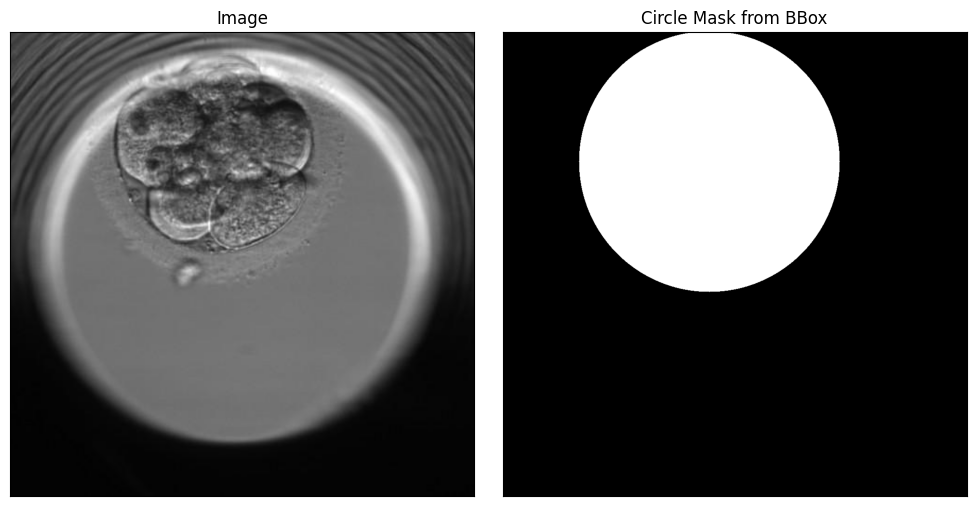

In [43]:
import random, matplotlib.pyplot as plt, numpy as np
if len(train_dataset) == 0:
    print("No samples in train_dataset to preview.")
else:
    i = random.randint(0, len(train_dataset)-1)
    sample = train_dataset[i]
    img_t = sample['image']  # C,H,W
    mask_t = sample['mask']  # 1,H,W
    c,h,w = img_t.shape
    np_img = (img_t.permute(1,2,0).numpy() * 255.0).clip(0,255).astype(np.uint8)
    if c == 1:
        np_img = np.repeat(np_img, 3, axis=2)
    elif c > 3:
        np_img = np_img[:, :, :3]
    mask_np = mask_t.squeeze(0).numpy().astype(np.uint8)
    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(10,5))
    axes[0].imshow(np_img)
    axes[0].set_title('Image')
    axes[1].imshow(mask_np, cmap='gray')
    axes[1].set_title('Circle Mask from BBox')
    for ax in axes:
        ax.set_xticks([]); ax.set_yticks([])
    plt.tight_layout()
    plt.show()

In [ ]:
# Define SAM processor and dataset wrapper BEFORE building sam_* datasets
from typing import Dict, Any
from PIL import Image
from transformers import SamProcessor

# Initialize the processor once (idempotent)
try:
    processor
except NameError:
    processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

class SAMDatasetLazy(torch.utils.data.Dataset):
    def __init__(self, base_dataset: H5LazyEmbryoDataset, processor, bbox_keys=("x1","y1","x2","y2")):
        self.base = base_dataset
        self.rows = base_dataset.rows
        self.processor = processor
        self.bx, self.by, self.bX, self.bY = bbox_keys

    def __len__(self):
        return len(self.base)

    def _get_bbox(self, row, w, h):
        # Prefer explicit bbox if available
        if all(k in row and row[k] is not None for k in (self.bx,self.by,self.bX,self.bY)):
            x1 = int(max(0, min(w-1, float(row[self.bx]))))
            y1 = int(max(0, min(h-1, float(row[self.by]))))
            x2 = int(max(0, min(w-1, float(row[self.bX]))))
            y2 = int(max(0, min(h-1, float(row[self.bY]))))
            if x2 > x1 and y2 > y1:
                return [x1, y1, x2, y2]
        # Fallback: derive from circular mask center/radius if present
        cx = row.get('cx'); cy = row.get('cy'); r = row.get('r')
        if cx is not None and cy is not None and r is not None:
            cx, cy, r = float(cx), float(cy), float(r)
            x1 = int(max(0, min(w-1, cx - r)))
            y1 = int(max(0, min(h-1, cy - r)))
            x2 = int(max(0, min(w-1, cx + r)))
            y2 = int(max(0, min(h-1, cy + r)))
            if x2 > x1 and y2 > y1:
                return [x1, y1, x2, y2]
        # Last resort: center box covering middle of the image
        bw = int(w*0.3); bh = int(h*0.3)
        x1 = (w - bw)//2; y1 = (h - bh)//2
        x2 = x1 + bw; y2 = y1 + bh
        return [x1, y1, x2, y2]

    def __getitem__(self, idx) -> Dict[str, Any]:
        sample = self.base[idx]
        row = self.rows[idx]
        # Convert CxHxW float[0,1] -> HxWxC uint8 RGB
        img_t = sample['image']  # C,H,W
        if img_t.ndim != 3:
            raise ValueError(f"Unexpected image tensor shape: {tuple(img_t.shape)}")
        c, h, w = img_t.shape
        np_img = (img_t.permute(1,2,0).numpy() * 255.0).clip(0,255).astype(np.uint8)
        if c == 1:
            np_img = np.repeat(np_img, 3, axis=2)
        elif c > 3:
            np_img = np_img[:, :, :3]
        bbox = self._get_bbox(row, w, h)
        # Prepare inputs for SAM
        inputs = self.processor(np_img, input_boxes=[[bbox]], return_tensors="pt")
        inputs = {k: v.squeeze(0) for k,v in inputs.items()}  # remove batch dim
        # Attach ground truth mask (HxW -> float32)
        gt = sample['mask'].squeeze(0).float()  # HxW
        inputs['ground_truth_mask'] = gt
        return inputs

Defined SAMDatasetLazy and initialized processor (moved earlier for correct execution order)


In [ ]:
import random
sam_train = SAMDatasetLazy(train_dataset, processor)
sam_test = SAMDatasetLazy(test_dataset, processor)

# Subset to at most 500 samples to speed up validation runs
subset_size = min(500,len(sam_train))
random.seed(42)
indices = list(range(len(sam_train)))
random.shuffle(indices)
subset_indices = indices[:subset_size]

sam_train_subset = torch.utils.data.Subset(sam_train, subset_indices)

sam_train_loader = DataLoader(sam_train_subset, batch_size=2, shuffle=True, num_workers=0, pin_memory=True)

print(f"Using subset of {len(sam_train_subset)} samples (from {len(sam_train)})")

batch = next(iter(sam_train_loader))
print({k: v.shape if hasattr(v, 'shape') else type(v) for k,v in batch.items()})

Using subset of 500 samples (from 2529536)
{'pixel_values': torch.Size([2, 3, 1024, 1024]), 'original_sizes': torch.Size([2, 2]), 'reshaped_input_sizes': torch.Size([2, 2]), 'input_boxes': torch.Size([2, 1, 4]), 'ground_truth_mask': torch.Size([2, 1024, 1024])}


In [ ]:
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-base")

# Freeze encoder components; train only mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionSdpaAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm((25

In [ ]:
from torch.optim import Adam
import monai
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [48]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import interpolate

num_epochs = 10
model.train()

debug_once = True
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(sam_train_loader):
        # Move to device
        pixel_values = batch["pixel_values"].to(device)
        input_boxes = batch["input_boxes"].to(device)
        gt_masks = batch["ground_truth_mask"].float().to(device)  # [B, H, W]

        # Forward
        outputs = model(pixel_values=pixel_values, input_boxes=input_boxes, multimask_output=False)
        pred_masks = outputs.pred_masks  # could be [B, 1, 1, H, W] or [B, 1, H, W]

        # Normalize pred_masks to [B, 1, H, W]
        if pred_masks.dim() == 5:
            # [B, N, C, H, W] -> take first mask set
            pred_masks = pred_masks[:, 0]  # [B, C, H, W]
        if pred_masks.dim() == 4 and pred_masks.shape[1] != 1:
            # If multiple channels/masks, keep the first channel
            pred_masks = pred_masks[:, :1]
        if pred_masks.dim() == 3:
            pred_masks = pred_masks.unsqueeze(1)
        pred_masks = pred_masks.float()

        # Resize ground truth to predicted resolution [B,1,H_out,W_out]
        if gt_masks.dim() == 3:
            gt_masks = gt_masks.unsqueeze(1)
        if gt_masks.shape[-2:] != pred_masks.shape[-2:]:
            gt_masks = interpolate(gt_masks, size=pred_masks.shape[-2:], mode='bilinear', align_corners=False)

        if debug_once:
            print({
                'pred_masks_shape': tuple(pred_masks.shape),
                'gt_masks_shape': tuple(gt_masks.shape),
            })
            debug_once = False

        loss = seg_loss(pred_masks, gt_masks)

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())

    print(f"EPOCH: {epoch} | mean loss: {mean(epoch_losses):.4f}")

print("Training loop finished")

  0%|          | 1/250 [00:00<00:51,  4.82it/s]

{'pred_masks_shape': (2, 1, 256, 256), 'gt_masks_shape': (2, 1, 256, 256)}


100%|██████████| 250/250 [00:51<00:00,  4.83it/s]


EPOCH: 0 | mean loss: 0.2052


100%|██████████| 250/250 [00:51<00:00,  4.84it/s]


EPOCH: 1 | mean loss: 0.1108


100%|██████████| 250/250 [00:51<00:00,  4.83it/s]


EPOCH: 2 | mean loss: 0.0776


100%|██████████| 250/250 [00:51<00:00,  4.83it/s]


EPOCH: 3 | mean loss: 0.0623


100%|██████████| 250/250 [00:51<00:00,  4.82it/s]


EPOCH: 4 | mean loss: 0.0530


100%|██████████| 250/250 [00:51<00:00,  4.82it/s]


EPOCH: 5 | mean loss: 0.0478


100%|██████████| 250/250 [00:51<00:00,  4.85it/s]


EPOCH: 6 | mean loss: 0.0426


100%|██████████| 250/250 [00:51<00:00,  4.87it/s]


EPOCH: 7 | mean loss: 0.0400


100%|██████████| 250/250 [00:51<00:00,  4.84it/s]


EPOCH: 8 | mean loss: 0.0382


100%|██████████| 250/250 [00:51<00:00,  4.83it/s]

EPOCH: 9 | mean loss: 0.0348
Training loop finished


In [49]:
# Save the model's state dictionary to a file
torch.save(model.state_dict(), "trained_model/mito_model_checkpoint.pth")

# INFERENCE

In [50]:
# Load processor and model weights for inference
from transformers import SamModel, SamProcessor
import torch

# Reuse existing processor if available; otherwise load
try:
    processor
except NameError:
    processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

my_mito_model = SamModel.from_pretrained("facebook/sam-vit-base")
state_dict = torch.load("trained_model/mito_model_checkpoint.pth", map_location="cpu")
my_mito_model.load_state_dict(state_dict)

device = "cuda" if torch.cuda.is_available() else "cpu"
my_mito_model.to(device)
my_mito_model.eval()

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionSdpaAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm((25

In [51]:
device = "cuda" if torch.cuda.is_available() else "cpu"
my_mito_model.to(device)
my_mito_model.eval()
print(f"Inference device: {device}")

Inference device: cuda


{'img_shape': (1024, 1024, 3), 'prob_min': 0.5, 'prob_max': 0.7310585379600525, 'prob_mean': 0.570097804069519, 'mask_shape': (1024, 1024), 'mask_sum': 318114}


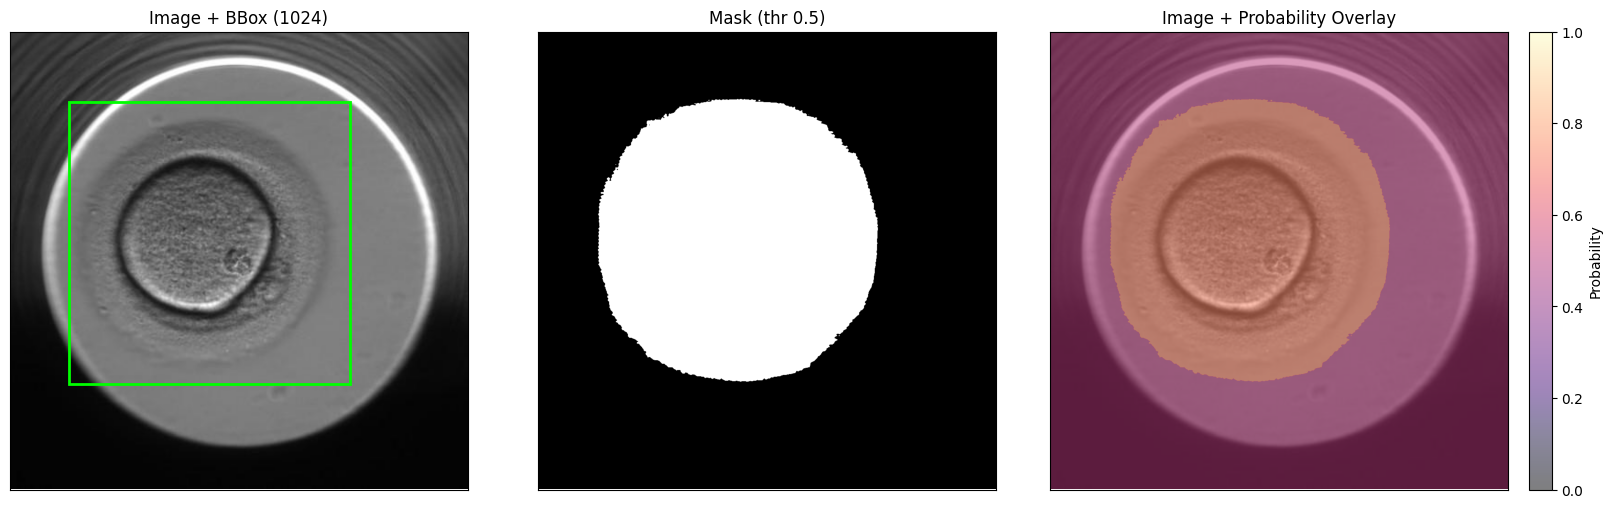

In [52]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt

if len(test_dataset) == 0:
    raise RuntimeError("No test samples available.")
idx = random.randint(0, len(test_dataset)-1)

base_sample = test_dataset[idx]
row = test_rows[idx]
# Convert CxHxW [0,1] -> HxWxC uint8 for visualization and processor
img_t = base_sample['image']
c,h,w = img_t.shape
np_img = (img_t.permute(1,2,0).numpy() * 255.0).clip(0,255).astype(np.uint8)
if c == 1:
    np_img = np.repeat(np_img, 3, axis=2)
elif c > 3:
    np_img = np_img[:, :, :3]

# Ensure target size is 1024x1024 as per your CSV bboxes
if (h, w) != (1024, 1024):
    print(f"Warning: image is {h}x{w}, expected 1024x1024. Resizing display copy only; CSV bbox stays in 1024 space.")
    # Create a resized copy just for display & processor; keep original (h,w) for indexing
    import cv2  # ensure available in this cell
    disp_img = cv2.resize(np_img, (1024, 1024), interpolation=cv2.INTER_AREA)
else:
    disp_img = np_img

# Use CSV bbox directly (already 1024x1024 space)
x1 = int(max(0, min(1023, float(row.get('x1', 0)))))
y1 = int(max(0, min(1023, float(row.get('y1', 0)))))
x2 = int(max(0, min(1023, float(row.get('x2', 1023)))))
y2 = int(max(0, min(1023, float(row.get('y2', 1023)))))
if not (x2 > x1 and y2 > y1):
    # fallback to center box in 1024 space
    bw = int(1024*0.3); bh = int(1024*0.3); x1=(1024-bw)//2; y1=(1024-bh)//2; x2=x1+bw; y2=y1+bh
bbox = [x1, y1, x2, y2]

# Prepare inputs with the display image at 1024 and CSV bbox
inputs = processor(disp_img, input_boxes=[[bbox]], return_tensors="pt")
inputs = {k: v.to(device) for k, v in inputs.items()}

my_mito_model.eval()
with torch.no_grad():
    outputs = my_mito_model(**inputs, multimask_output=True)

# Pick best mask index robustly
best_idx = 0
if hasattr(outputs, 'iou_scores') and outputs.iou_scores is not None:
    iou = outputs.iou_scores
    if iou.ndim == 2:
        iou = iou[0]
    best_idx = int(torch.argmax(iou).item())

# Map to image space via post-processing
post = processor.post_process_masks(
    outputs.pred_masks, inputs["original_sizes"], inputs["reshaped_input_sizes"]
)
# Normalize shapes to get a single 2D mask logit map
m = post[0]
if not isinstance(m, torch.Tensor):
    m = torch.as_tensor(m)
# Accept (1,C,H,W) -> (C,H,W), (C,H,W) -> select, (H,W) -> use directly
if m.ndim == 4:
    m = m[0]
if m.ndim == 3:
    sel = int(min(max(best_idx, 0), m.shape[0]-1))
    mask_logits = m[sel]
elif m.ndim == 2:
    mask_logits = m
else:
    mask_logits = m.squeeze()

# Convert logits to probability map (HxW)
prob_map = torch.sigmoid(mask_logits.float()).cpu().numpy()
if prob_map.ndim == 3:
    # In rare cases, squeeze any singleton channel dim
    prob_map = np.squeeze(prob_map)
pred_mask = (prob_map > 0.5).astype(np.uint8)

print({
    'img_shape': disp_img.shape,
    'prob_min': float(prob_map.min()) if prob_map.size else None,
    'prob_max': float(prob_map.max()) if prob_map.size else None,
    'prob_mean': float(prob_map.mean()) if prob_map.size else None,
    'mask_shape': tuple(pred_mask.shape),
    'mask_sum': int(pred_mask.sum()),
})

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
axes[0].imshow(disp_img)
# Draw bbox
axes[0].add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='lime', linewidth=2))
axes[0].set_title("Image + BBox (1024)")
axes[1].imshow(pred_mask, cmap='gray')
axes[1].set_title("Mask (thr 0.5)")
# Overlay probability map on image with alpha
axes[2].imshow(disp_img)
overlay = axes[2].imshow(prob_map, vmin=0.0, vmax=1.0, cmap='magma', alpha=0.5)
axes[2].set_title("Image + Probability Overlay")
for ax in axes:
    ax.set_xticks([]); ax.set_yticks([])
plt.tight_layout()
plt.colorbar(overlay, ax=axes[2], fraction=0.046, pad=0.04, label='Probability')
plt.show()